In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
import torch.nn.functional as F
import pandas as pd
import torch.nn.utils.parametrize as parametrize
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import r2_score, mean_squared_error
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
start = 1
data = pd.read_csv("data-B90102-30m.csv")
room = data["room_temp"]
airflow = data["airflow_cur"]
supply = data["supply_temp"]

In [ ]:
delta =  np.array(room[start:-1]) - np.array(room[start-1:-2])
delta_supply = np.array(supply[start+1:]) - np.array(supply[start:-1])
delta_air = np.array(airflow[start+1:]) - np.array(airflow[start:-1])

temp_cur = np.array(room[start:-1]).reshape(-1,1)
temp = np.array(room[start-1:-1-1]).reshape(-1,1)
output = np.array(room[start+1:]).reshape(-1,1)
air = np.array(airflow[start:-1]).reshape(-1,1)
supply = np.array(supply[start:-1]).reshape(-1,1)

air_origin = torch.tensor(air).to(device).reshape(-1,1).float()
supply_origin = torch.tensor(supply).to(device).reshape(-1,1).float()
temp_origin = torch.tensor(temp).to(device).reshape(-1,1).float()
output_origin = torch.tensor(output).to(device).reshape(-1,1).float()
temp_cur = torch.tensor(temp_cur).to(device).reshape(-1,1).float()

delta = torch.tensor(delta).reshape(-1,1).float().to(device)/(max(temp_origin) - min(temp_origin))
delta_supply = torch.tensor(delta_supply).reshape(-1,1).float().to(device)/(max(supply_origin) - min(supply_origin))
delta_air = torch.tensor(delta_air).reshape(-1,1).float().to(device)/(max(air_origin)- min(air_origin))

delta = torch.concat((delta, delta_supply, delta_air), dim =1)

In [ ]:
air = (air_origin - min(air_origin))/(max(air_origin)- min(air_origin))
air = air.requires_grad_(True)
supply = (supply_origin - min(supply_origin))/(max(supply_origin) - min(supply_origin))
supply = supply.requires_grad_(True)
temp = (temp_origin - min(temp_origin))/(max(temp_origin) - min(temp_origin))
temp = temp.requires_grad_(True)
output = (output - min(output))/(max(output) - min(output))
output = torch.tensor(output).reshape(-1,1).float().to(device)
temp_cur = (temp_cur - min(temp_origin))/(max(temp_origin) - min(temp_origin))

In [ ]:
def data_split(N: int, N_end: int, temp_cur: torch.Tensor, temp: torch.Tensor, supply: torch.Tensor, air: torch.Tensor, output: torch.Tensor, delta: torch.Tensor):
    temp_cur_tr = temp_cur[N:N_end]
    temp_tr = temp[N:N_end]
    supply_tr = supply[N:N_end]
    air_tr = air[N:N_end]
    output_tr = output[N:N_end]
    delta_tr = delta[N:N_end].requires_grad_(True)
    return temp_cur_tr, temp_tr, supply_tr, air_tr, output_tr, delta_tr

In [15]:
class Taylor_Net(nn.Module):
    def __init__(self, n=1):
        super(Taylor_Net, self).__init__()
        self.n = n
        self.fc1 = nn.Linear(3, 3*self.n)
        self.fc2_1 = nn.Linear(self.n, 1)
        self.fc2_2 = nn.Linear(self.n, 1)
        self.fc2_3 = nn.Linear(self.n, 1)

    def forward(self, x, y, z):
        x = torch.cat((x, y, z), dim=1)
        x = F.relu(self.fc1(x))
        x_1 = self.fc2_1(x[:, 0:self.n].reshape(-1, self.n))
        y_1 = self.fc2_2(x[:, self.n:2*self.n].reshape(-1, self.n))
        z_1 = self.fc2_3(x[:, 2*self.n:3*self.n].reshape(-1, self.n))
        x = torch.cat((x_1, y_1, z_1), dim=1)
        return x

In [ ]:
def calculate_next(model, temp_cur_t, temp_t, supply_t, air_t, delta_t):
    elementwise_product_t = torch.mul(model(temp_t, supply_t, air_t), delta_t)
    dot_products_t = torch.sum(elementwise_product_t, dim=1, keepdim=True)
    output_temp_t = temp_cur_t + dot_products_t
    return output_temp_t

In [ ]:
def calculate_next_2(model, temp_cur_t, temp_t, supply_t, air_t, delta_t):
    temp_t = temp_t.requires_grad_(True)
    supply_t = supply_t.requires_grad_(True)
    air_t = air_t.requires_grad_(True)
    elementwise_product_t = torch.mul(model(temp_t, supply_t, air_t), delta_t)
    c = model(temp_t, supply_t, air_t)
    dot_products_t = torch.sum(elementwise_product_t, dim=1, keepdim=True)
    output_temp_t = temp_cur_t + dot_products_t
    grad_outputs = torch.ones_like(c)[:, 0]
    dc_dx_dx = torch.autograd.grad(outputs=c[:, 0], inputs=temp_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dx_dy = torch.autograd.grad(outputs=c[:, 0], inputs=supply_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dx_dz = torch.autograd.grad(outputs=c[:, 0], inputs=air_t, grad_outputs=grad_outputs, retain_graph=True)[0]
        
    dc_dy_dy = torch.autograd.grad(outputs=c[:, 1], inputs=supply_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dy_dx = torch.autograd.grad(outputs=c[:, 1], inputs=temp_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dy_dz = torch.autograd.grad(outputs=c[:, 1], inputs=air_t, grad_outputs=grad_outputs, retain_graph=True)[0]
   
    dc_dz_dz = torch.autograd.grad(outputs=c[:, 2], inputs=air_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dz_dx = torch.autograd.grad(outputs=c[:, 2], inputs=temp_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dz_dy = torch.autograd.grad(outputs=c[:, 2], inputs=supply_t, grad_outputs=grad_outputs, retain_graph=True)[0]

    dx = delta_t[:, 0].reshape(-1,1)
    dy = delta_t[:, 1].reshape(-1,1)
    dz = delta_t[:, 2].reshape(-1,1)
        
    t_next = output_temp_t + (dc_dx_dx*dx**2 + dc_dy_dy*dy**2 + dc_dz_dz*dz**2 + (dc_dx_dy + dc_dy_dx)*dx*dy + (dc_dx_dz + dc_dz_dx)*dx*dz + (dc_dy_dz+dc_dz_dy)*dy*dz) / 2
    return t_next

In [ ]:
def train_model(model, optimizer, criterion, temp_cur_tr, temp_tr, supply_tr, air_tr, output_temp_tr, delta_tr, scheduler=None, epochs=20000, patience=1000, threshold=1e-10, print_interval=5000):
    prev_loss = float('inf')
    no_improvement_counter = 0
    loss_array = []
    r2_array = []
    point = []
    last_loss = 0
    for epoch in range(epochs):
        model.train() 
        optimizer.zero_grad()
        # Forward pass
        elementwise_product = torch.mul(model(temp_tr, supply_tr, air_tr), delta_tr)
        term = F.relu(-model(temp_tr, supply_tr, air_tr)[:, 1].reshape(-1,1))
        dot_products = torch.sum(elementwise_product, dim=1, keepdim=True)
        output = temp_cur_tr + dot_products
        alpha = 0.25 
        regularized_term = alpha * term.mean()
        loss = criterion(output, output_temp_tr) + regularized_term
        loss_array.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        last_loss = loss
        if scheduler:
            scheduler.step()
        if epoch % 50 == 0:
            loss_array.append(loss.item())
            r2_score_val = r2_score(output_temp_tr.to("cpu").detach().numpy(), output.to("cpu").detach().numpy())
            r2_array.append(r2_score_val)
            point.append(epoch // 50)
        if epoch % print_interval == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.9f}')
        if abs(prev_loss - loss.item()) < threshold:
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0 
        prev_loss = loss.item()
        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no significant improvement.')
            break
        if loss.item() < 0.0000000087022:
            print(f'Early stopping at epoch {epoch+1} due to very low loss.')
            print("min of loss function is", min(loss_array))
            break
    return loss.item()

In [ ]:
epochs = 20000
patience = 1000
threshold = 1e-15
decay_factor = 1.0 
decay_step_size = 1000 

N_start, N_end = 360, 540
Ns_t, Ne_t = 950, 1050
Ns_val, Ne_val = 800, 900
temp_cur_tr, temp_tr, supply_tr, air_tr, output_tr, delta_tr = data_split(N_start, N_end, temp_cur, temp, supply, air, output, delta)
temp_cur_t, temp_t, supply_t, air_t, output_t, delta_t = data_split(Ns_t, Ne_t, temp_cur, temp, supply, air, output, delta)
temp_cur_val, temp_val, supply_val, air_val, output_val, delta_val = data_split(Ns_val, Ne_val, temp_cur, temp, supply, air, output, delta)

In [ ]:
def evaluate_model_1(model_path, model_class, num_predict, device='cpu'):
    r2_loop = []
    model = model_class(n=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    t_next = calculate_next(model, temp_cur_t[0:-num_predict], temp_t[0:-num_predict], supply_t[0:-num_predict], air_t[0:-num_predict], delta_t[0:-num_predict])
    r2 = r2_score(output_t[:-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    thresh = 1
    delta = t_next - temp_cur_t[0:-num_predict]
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta_t[1:1-num_predict, 1].reshape(-1,1), delta_t[1:1-num_predict, 2].reshape(-1,1)), dim = 1)
    
    t_next_2 = calculate_next(model, t_next, temp_t[1:1-num_predict], supply_t[1:1-num_predict], air_t[1:1-num_predict], delta)
    r2 = r2_score(output_t[1:1-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    delta = t_next_2 - t_next
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta_t[2:2-num_predict, 1].reshape(-1,1), delta_t[2:2-num_predict, 2].reshape(-1,1)), dim = 1)
    
    for i in range(2, num_predict):
        t_next_3 = calculate_next(model, t_next_2, t_next, supply_t[i:i-num_predict], air_t[i:i-num_predict], delta)
        r2 = r2_score(output_t[i:i-num_predict].to("cpu").detach().numpy(), t_next_3.to("cpu").detach().numpy())
        r2_loop.append(r2)
        delta = t_next_3 - t_next_2
        delta = torch.clamp(delta, max=thresh, min = -thresh) 
        if i < num_predict-1:
            delta = torch.cat((delta, delta_t[1+i:1+i-num_predict, 1].reshape(-1,1), delta_t[1+i:1+i-num_predict, 2].reshape(-1,1)), dim = 1)
            t_next = t_next_2
            t_next_2 = t_next_3
    return r2_loop

In [ ]:
learning = np.arange(0.001, 0.1, 0.002)
num_t = 1
current_mse_score = 0
mse = []
mse.append(1.0)
for lr in learning:
    # Train model_Taylor
    model_Taylor = Taylor_Net().to(device)
    optimizer = optim.Adam(model_Taylor.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=decay_step_size, gamma=decay_factor)

    loss_Tay = train_model(
        model=model_Taylor,
        optimizer=optimizer,
        criterion=nn.MSELoss(),
        temp_cur_tr= temp_cur_tr,
        temp_tr=temp_tr,
        supply_tr=supply_tr,
        air_tr=air_tr,
        output_temp_tr=output_tr,
        delta_tr=delta_tr,
        scheduler=scheduler, 
        epochs=epochs,
        patience=patience,
        threshold=threshold,
        print_interval=5000
    )
    if loss_Tay < 10.1:
            t_next_t = calculate_next(model_Taylor,temp_cur_val, temp_val, supply_val, air_val, delta_val)
            current_mse_score = mean_squared_error(output_val.to("cpu").detach().numpy(), t_next_t.to("cpu").detach().numpy())
            if current_mse_score > -10:
                if current_mse_score < min(mse):
                    torch.save(model_Taylor.state_dict(), f"model_Taylor_1st_loss_5min.pth")
                    mse.append(current_mse_score)
                    print(current_mse_score)

Epoch [1/20000], Loss: 0.005880089
Epoch [5001/20000], Loss: 0.000325709
Epoch [10001/20000], Loss: 0.000325676
Epoch [15001/20000], Loss: 0.000326109
0.00030712842
Epoch [1/20000], Loss: 0.005620157
Epoch [5001/20000], Loss: 0.000333092
Early stopping at epoch 7151 due to no significant improvement.
0.00030382382
Epoch [1/20000], Loss: 0.002371625
Epoch [5001/20000], Loss: 0.000322318
Epoch [10001/20000], Loss: 0.000322350
Epoch [15001/20000], Loss: 0.000321841
Epoch [1/20000], Loss: 0.059093248
Epoch [5001/20000], Loss: 0.000312266
Epoch [10001/20000], Loss: 0.000311642
Epoch [15001/20000], Loss: 0.000311222
0.0002936226
Epoch [1/20000], Loss: 0.026893560
Epoch [5001/20000], Loss: 0.000333092
Early stopping at epoch 6514 due to no significant improvement.
Epoch [1/20000], Loss: 0.143184066
Epoch [5001/20000], Loss: 0.000325868
Epoch [10001/20000], Loss: 0.000329483
Epoch [15001/20000], Loss: 0.000326275
Epoch [1/20000], Loss: 0.074358761
Epoch [5001/20000], Loss: 0.000279344
Epoch [1

[0.9806225248689782,
 0.9576728348852515,
 0.9451736663035405,
 0.9173553989941485,
 0.903008826649852,
 0.8765132044195988,
 0.8442818641322198]

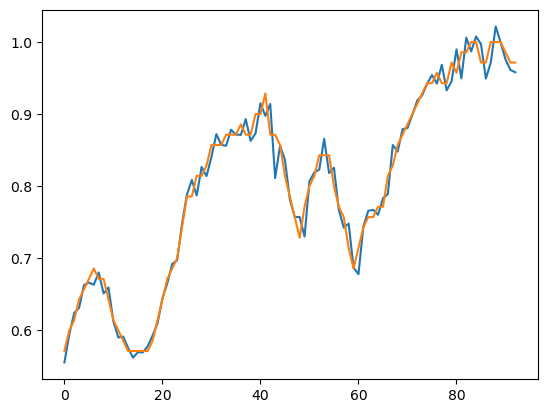

In [ ]:
num_predict = 7

model_path = f"model_Taylor_1st_loss_5min.pth"

model = Taylor_Net().to(device)
model.load_state_dict(torch.load(model_path))
t_next = calculate_next(model, temp_cur_t[0:-num_predict], temp_t[0:-num_predict], supply_t[0:-num_predict], air_t[0:-num_predict], delta_t[0:-num_predict])
plt.plot(t_next.to("cpu").detach().numpy())
plt.plot(output_t[:-num_predict].to("cpu").detach().numpy())
evaluate_model_1(model_path, model_class=Taylor_Net, num_predict=num_predict, device=device)

In [ ]:
# Modify train_model to accept scheduler
def train_model_2(model, optimizer, criterion, temp_cur_tr, temp_tr, supply_tr, air_tr, output_temp_tr, delta_tr, scheduler=None, epochs=20000, patience=1000, threshold=1e-10, print_interval=5000):
    prev_loss = float('inf')
    no_improvement_counter = 0
    loss_array = []
    r2_array = []
    last_loss = 0
    point = []
    for epoch in range(epochs):
        model.train()  
        optimizer.zero_grad()
        elementwise_product = torch.mul(model(temp_tr, supply_tr, air_tr), delta_tr)
        c = model(temp_tr, supply_tr, air_tr)
        dot_products = torch.sum(elementwise_product, dim=1, keepdim=True)
        output = temp_cur_tr + dot_products
    
        grad_outputs = torch.ones_like(c)[:, 0]

        dc_dx_dx = torch.autograd.grad(outputs=c[:, 0], inputs=temp_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dx_dy = torch.autograd.grad(outputs=c[:, 0], inputs=supply_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dx_dz = torch.autograd.grad(outputs=c[:, 0], inputs=air_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        
        dc_dy_dy = torch.autograd.grad(outputs=c[:, 1], inputs=supply_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dy_dx = torch.autograd.grad(outputs=c[:, 1], inputs=temp_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dy_dz = torch.autograd.grad(outputs=c[:, 1], inputs=air_tr, grad_outputs=grad_outputs, retain_graph=True)[0]

        
        dc_dz_dz = torch.autograd.grad(outputs=c[:, 2], inputs=air_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dz_dx = torch.autograd.grad(outputs=c[:, 2], inputs=temp_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        dc_dz_dy = torch.autograd.grad(outputs=c[:, 2], inputs=supply_tr, grad_outputs=grad_outputs, retain_graph=True)[0]
        
        length = len(temp_tr)

        dx = delta_tr[:, 0].reshape(-1,1)
        dy = delta_tr[:, 1].reshape(-1,1)
        dz = delta_tr[:, 2].reshape(-1,1)
        t_next = output + (dc_dx_dx*dx**2 + dc_dy_dy*dy**2 + dc_dz_dz*dz**2 + (dc_dx_dy + dc_dy_dx)*dx*dy + (dc_dx_dz + dc_dz_dx)*dx*dz + (dc_dy_dz+dc_dz_dy)*dy*dz) / 2
        
        term = F.relu(-model_Taylor(temp_tr, supply_tr, air_tr)[:, 1].reshape(-1,1))
        alpha = 0.25
        regularized_term = alpha * term.mean()
        
        loss = criterion(t_next, output_temp_tr)
        loss_array.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        last_loss = loss
        if scheduler:
            scheduler.step()
        if epoch % 50 ==0:
            r2_score_val = r2_score(output_temp_tr.to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
            r2_array.append(r2_score_val)
            point.append(epoch // 50)
        if epoch % print_interval == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.9f}')
        if abs(prev_loss - loss.item()) < threshold:
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0  
        prev_loss = loss.item()
        if no_improvement_counter >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no significant improvement.')
            break
        if loss.item() < 0.0000075052:
            print(f'Early stopping at epoch {epoch+1} due to very low loss.')
            print("min of loss function is", min(loss_array))
            break
    
    return loss.item()

In [ ]:
def calculate_next_2(model, temp_cur_t, temp_t, supply_t, air_t, delta_t):
    temp_t = temp_t.requires_grad_(True)
    supply_t = supply_t.requires_grad_(True)
    air_t = air_t.requires_grad_(True)
    elementwise_product_t = torch.mul(model(temp_t, supply_t, air_t), delta_t)
    c = model(temp_t, supply_t, air_t)
    dot_products_t = torch.sum(elementwise_product_t, dim=1, keepdim=True)
    output_temp_t = temp_cur_t + dot_products_t
    grad_outputs = torch.ones_like(c)[:, 0]
    dc_dx_dx = torch.autograd.grad(outputs=c[:, 0], inputs=temp_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dx_dy = torch.autograd.grad(outputs=c[:, 0], inputs=supply_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dx_dz = torch.autograd.grad(outputs=c[:, 0], inputs=air_t, grad_outputs=grad_outputs, retain_graph=True)[0]
        
    dc_dy_dy = torch.autograd.grad(outputs=c[:, 1], inputs=supply_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dy_dx = torch.autograd.grad(outputs=c[:, 1], inputs=temp_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dy_dz = torch.autograd.grad(outputs=c[:, 1], inputs=air_t, grad_outputs=grad_outputs, retain_graph=True)[0]
   
    dc_dz_dz = torch.autograd.grad(outputs=c[:, 2], inputs=air_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dz_dx = torch.autograd.grad(outputs=c[:, 2], inputs=temp_t, grad_outputs=grad_outputs, retain_graph=True)[0]
    dc_dz_dy = torch.autograd.grad(outputs=c[:, 2], inputs=supply_t, grad_outputs=grad_outputs, retain_graph=True)[0]

    dx = delta_t[:, 0].reshape(-1,1)
    dy = delta_t[:, 1].reshape(-1,1)
    dz = delta_t[:, 2].reshape(-1,1)
        
    t_next = output_temp_t + (dc_dx_dx*dx**2 + dc_dy_dy*dy**2 + dc_dz_dz*dz**2 + (dc_dx_dy + dc_dy_dx)*dx*dy + (dc_dx_dz + dc_dz_dx)*dx*dz + (dc_dy_dz+dc_dz_dy)*dy*dz) / 2
    return t_next

In [ ]:
def evaluate_model_2(model_path, model_class, num_predict, device='cpu'):
    r2_loop = []
    model = model_class(n=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    t_next = calculate_next_2(model, temp_cur_t[0:-num_predict], temp_t[0:-num_predict], supply_t[0:-num_predict], air_t[0:-num_predict], delta_t[0:-num_predict])
    r2 = r2_score(output_t[:-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    thresh = 1
    delta = t_next - temp_cur_t[0:-num_predict]
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta_t[1:1-num_predict, 1].reshape(-1,1), delta_t[1:1-num_predict, 2].reshape(-1,1)), dim = 1)
    
    t_next_2 = calculate_next_2(model, t_next, temp_t[1:1-num_predict], supply_t[1:1-num_predict], air_t[1:1-num_predict], delta)
    r2 = r2_score(output_t[1:1-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    delta = t_next_2 - t_next
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta_t[2:2-num_predict, 1].reshape(-1,1), delta_t[2:2-num_predict, 2].reshape(-1,1)), dim = 1)
    
    for i in range(2, num_predict):
        t_next_3 = calculate_next_2(model, t_next_2, t_next, supply_t[i:i-num_predict], air_t[i:i-num_predict], delta)
        r2 = r2_score(output_t[i:i-num_predict].to("cpu").detach().numpy(), t_next_3.to("cpu").detach().numpy())
        r2_loop.append(r2)
        delta = t_next_3 - t_next_2
        delta = torch.clamp(delta, max=thresh, min = -thresh) 
        if i < num_predict-1:
            delta = torch.cat((delta, delta_t[1+i:1+i-num_predict, 1].reshape(-1,1), delta_t[1+i:1+i-num_predict, 2].reshape(-1,1)), dim = 1)
            t_next = t_next_2
            t_next_2 = t_next_3
    return r2_loop

In [ ]:
learning = np.arange(0.0001, 0.01, 0.0002)
num_t = 1
current_mse_score = 0
mse = []
mse.append(0.000287086)
for lr in learning:
    for i in range(num_t):
        n_value = 1
        model_path = f"model_Taylor_1st_loss_5min.pth"
        model_Taylor = Taylor_Net(n=n_value).to(device)
        model_Taylor.load_state_dict(torch.load(model_path))
        optimizer = optim.Adam(model_Taylor.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=decay_step_size, gamma=decay_factor)
        loss_Tay = train_model_2(
            model=model_Taylor,
            optimizer=optimizer,
            criterion=nn.MSELoss(),
            temp_cur_tr= temp_cur_tr,
            temp_tr=temp_tr,
            supply_tr=supply_tr,
            air_tr=air_tr,
            output_temp_tr=output_tr,
            delta_tr=delta_tr,
            scheduler=scheduler,  
            epochs=3000,
            patience=patience,
            threshold=threshold,
            print_interval=5000
        )
        if loss_Tay < 10.1:
            t_next_t = calculate_next_2(model_Taylor, temp_cur_val, temp_val, supply_val, air_val, delta_val)
            current_mse_score = mean_squared_error(output_val.to("cpu").detach().numpy(), t_next_t.to("cpu").detach().numpy())
            if current_mse_score > -10:
                if current_mse_score < min(mse):
                    torch.save(model_Taylor.state_dict(), f"model_Taylor_2nd_loss_5_mins.pth")
                    mse.append(current_mse_score)
                    print(current_mse_score)

In [ ]:
num_predict = 7

model_path = f"model_Taylor_2nd_loss_5_mins.pth"
evaluate_model_2(model_path, model_class=Taylor_Net, num_predict=num_predict, device=device)

[0.9800539143394313,
 0.9568989812056183,
 0.9437286471587181,
 0.916162713301424,
 0.9034038067031734,
 0.878113599004022,
 0.847786032088796]

In [ ]:
def rmse_model_1(model_path, model_class, num_predict, device='cpu'):
    r2_loop = []
    # Load the model
    model = model_class(n=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    # Ensure the test data is the same as when you calculated the r2_score previously
    t_next = calculate_next(model, temp_cur_t[0:-num_predict], temp_t[0:-num_predict], supply_t[0:-num_predict], air_t[0:-num_predict], delta_t[0:-num_predict])
    r2 = mean_squared_error(output_t[:-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    thresh = 1
    delta = t_next - temp_cur_t[0:-num_predict]
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta_t[1:1-num_predict, 1].reshape(-1,1), delta_t[1:1-num_predict, 2].reshape(-1,1)), dim = 1)
    
    t_next_2 = calculate_next(model, t_next, temp_t[1:1-num_predict], supply_t[1:1-num_predict], air_t[1:1-num_predict], delta)
    r2 = mean_squared_error(output_t[1:1-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    delta = t_next_2 - t_next
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta_t[2:2-num_predict, 1].reshape(-1,1), delta_t[2:2-num_predict, 2].reshape(-1,1)), dim = 1)
    
    for i in range(2, num_predict):
        t_next_3 = calculate_next(model, t_next_2, t_next, supply_t[i:i-num_predict], air_t[i:i-num_predict], delta)
        r2 = mean_squared_error(output_t[i:i-num_predict].to("cpu").detach().numpy(), t_next_3.to("cpu").detach().numpy())
        r2_loop.append(r2)
        delta = t_next_3 - t_next_2
        delta = torch.clamp(delta, max=thresh, min = -thresh) 
        if i < num_predict-1:
            delta = torch.cat((delta, delta_t[1+i:1+i-num_predict, 1].reshape(-1,1), delta_t[1+i:1+i-num_predict, 2].reshape(-1,1)), dim = 1)
            t_next = t_next_2
            t_next_2 = t_next_3
    return np.sqrt(r2_loop).reshape(-1,1)*7

In [ ]:
def rmse_model_2(model_path, model_class, num_predict, device='cpu'):
    r2_loop = []
    # Load the model
    model = model_class(n=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    # Ensure the test data is the same as when you calculated the r2_score previously
    t_next = calculate_next_2(model, temp_cur_t[0:-num_predict], temp_t[0:-num_predict], supply_t[0:-num_predict], air_t[0:-num_predict], delta_t[0:-num_predict])
    r2 = mean_squared_error(output_t[:-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    thresh = 1
    delta = t_next - temp_cur_t[0:-num_predict]
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta_t[1:1-num_predict, 1].reshape(-1,1), delta_t[1:1-num_predict, 2].reshape(-1,1)), dim = 1)
    
    t_next_2 = calculate_next_2(model, t_next, temp_t[1:1-num_predict], supply_t[1:1-num_predict], air_t[1:1-num_predict], delta)
    r2 = mean_squared_error(output_t[1:1-num_predict].to("cpu").detach().numpy(), t_next.to("cpu").detach().numpy())
    r2_loop.append(r2)
    delta = t_next_2 - t_next
    delta = torch.clamp(delta, max=thresh, min = -thresh)
    delta = torch.cat((delta, delta_t[2:2-num_predict, 1].reshape(-1,1), delta_t[2:2-num_predict, 2].reshape(-1,1)), dim = 1)
    
    for i in range(2, num_predict):
        t_next_3 = calculate_next_2(model, t_next_2, t_next, supply_t[i:i-num_predict], air_t[i:i-num_predict], delta)
        r2 = mean_squared_error(output_t[i:i-num_predict].to("cpu").detach().numpy(), t_next_3.to("cpu").detach().numpy())
        r2_loop.append(r2)
        delta = t_next_3 - t_next_2
        delta = torch.clamp(delta, max=thresh, min = -thresh) 
        if i < num_predict-1:
            delta = torch.cat((delta, delta_t[1+i:1+i-num_predict, 1].reshape(-1,1), delta_t[1+i:1+i-num_predict, 2].reshape(-1,1)), dim = 1)
            t_next = t_next_2
            t_next_2 = t_next_3
    return np.sqrt(r2_loop).reshape(-1,1)*7

In [ ]:
num_predict = 7

model_path = f"model_Taylor_1st_loss_5min.pth"

model = Taylor_Net().to(device)
model.load_state_dict(torch.load(model_path))
rmse_model_1(model_path, model_class=Taylor_Net, num_predict=num_predict, device=device)

array([[0.12672868],
       [0.18496574],
       [0.20852153],
       [0.2535883 ],
       [0.27227154],
       [0.3046829 ],
       [0.33958054]], dtype=float32)

In [ ]:
num_predict = 7

model_path = f"model_Taylor_2nd_loss_5_mins.pth"
rmse_model_2(model_path, model_class=Taylor_Net, num_predict=num_predict, device=device)

array([[0.1285746 ],
       [0.18664892],
       [0.21125157],
       [0.25541157],
       [0.27171656],
       [0.30270213],
       [0.33573794]], dtype=float32)